<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Gathering the scientific targets

Our goal here is to gather all the data locating potential scientific targets. These data are in a vector format, which we need to convert into a raster format to compute the site selection favorability. This is the opportunity to take into account the influence of the terrains on the rover's ability to reach a target.

To do so, we use a front propagation method called fast marching [[Sethian, 1996](http://doi.org/10.1073/pnas.93.4.1591)]. It uses a speed map to compute the time required to go from one or several initial cells to any cell inside the map. We already have a speed map which take into account the terrain variability from the previous notebook. Now, we can end up with the time required to drive from the scientific targets to any cell, and inversely.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.vector_management import *
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.fast_marching import *

import matplotlib.pyplot as plt

from shapely.geometry import Point

from skimage.transform import resize
import struct
import pandas as pd

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

We first choose the speed map for the fast marching. The first one is for a rover similar to NASA's Mars 2020 rover, the other ones for rovers with improving capabilities. The notebook must be run independently for each speed map.

In [4]:
speed_affix = ''
# speed_affix = '_DustTraversable'
# speed_affix = '_Speed100'
# speed_affix = '_Speed1000'
# speed_affix = '_Speed10000'

## Data to download before running the notebook

You can find below all the links to the scientific targets. The notebook does all the processing on these data to get the travel time maps, and can be run directly after downloading the data.

**Integrated Database of Planetary Features [from NASA Ames Center/ICA Commission on Planetary Cartography]**  
* **Point data (csv files)**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*   
https://planetarydatabase.files.wordpress.com/2016/09/idpf-9-23-2016-excel97.xls  
* **Vector data (shapefiles)**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
    - Glacial features  
    https://www.dropbox.com/s/59ncn9el0c0p4j7/glacial%20features.zip?dl=0  
    - Dune fields  
    https://www.dropbox.com/s/vcxayzsehooz1ns/dune-polygon.zip?dl=0  
    - Volcanoes  
    https://www.dropbox.com/s/vcs45d6lmrlb3q9/volcano.zip?dl=0  
    - Calderas  
    https://www.dropbox.com/s/vqrupcviapl7stg/caldera3.zip?dl=0  
    - Polygonal-ridge networks  
    https://www.dropbox.com/s/xremqowcqa35xco/polygonal_ridge.zip?dl=0  

**Mars Crater Database [from [Robbins and Hynek (2012)](http://doi.org/10.1029/2011JE003966)]**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*   
http://craters.sjrdesign.net/  (use the default search options) 

**Geologic map of Mars (3292) and of the northern plains of Mars (2888) [from USGS]**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology/NPlains_geology_SIM2888_2005.zip  
ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology/SIM3292_newGlobalGeology2014/SIM3292_MarsGlobalGeologicGIS_20M.zip  

**JMARS [from ASU's Mars Space Flight Facility]**  
*In* Human Exploration, Science Survey Maps  
*Once loaded, right-click on the data,* Open *,* Adjustments *,* Feature *,* Save all Features As  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
* Chloride exposures  
Called *2010 Chloride Survey* in JMARS  
*Save as Chloride-bearing-materials_Osterloo-2010.shp*  
* Carbonate exposures  
Called *2014 Aqueous Mineral Distribution* in JMARS (save only the points)  
*Save as Aqueous-Mineral-Distribution_Ehlmann-Edwards-2014.csv*  

**Hydrous mineral exposures [from Mars Express OMEGA]**  
*Save in CaseStudyMars_Data/MEX/OMEGA/*  
ftp://psa.esac.esa.int/pub/mirror/MARS-EXPRESS/OMEGA/MEX-M-OMEGA-5-DDR-GLOBAL-MAPS-V1.0/DATA/HYDROUS/HYDROUS_SITES_GEO_MAP.CSV 

**Sedimentary rock exposures [from Edwin Kite, based on [Malin et al. (2010)](http://doi.org/10.1555/mars.2010.0001)]**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
http://geosci.uchicago.edu/~kite/stereo/sedrocks_latlong.csv  

**Valley networks [from [Hynek et al. (2010)](http://doi.org/10.1029/2009JE003548)]**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/channels/Hynek/Hynek_Valley_Networks.zip  

**Small vents in the Tharsis province**  
*Save in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
http://astropedia.astrogeology.usgs.gov/download/Mars/Research/Volcanic/TharsisVents.zip  

**Alluvial fans (part 2)**  
*Provided with the notebooks as Alluvial-Fans_Metz-et-al-2009.csv in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
Metz et al. (2009)  
http://doi.org/doi:10.1029/2009JE003365   

**Young deltas**  
*Provided with the notebooks as Alluvial-Fans_Metz-et-al-2009.csv in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
Hauber et al. (2013)  
http://doi.org/doi:10.1002/jgre.20107  

**Subaqueous fans**  
*Provided with the notebooks as Alluvial-Fans_Metz-et-al-2009.csv in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
Metz et al. (2009)  
http://doi.org/doi:10.1029/2009JE003365  

**Outflow channels and large valleys**  
*Provided with the notebooks as Alluvial-Fans_Metz-et-al-2009.csv in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
Irwin and Grant (2009)  
ISBN: 978-0-511-63563-2  

**Potential hydrothermal systems**  
*Provided with the notebooks as Alluvial-Fans_Metz-et-al-2009.csv in CaseStudyMars_Data/Original_Data/Interpreted_Data/*  
* Farmer (1996)  
http://doi.org/10.1002/9780470514986.ch15  
* Dohm et al. (2000)  
http://adsabs.harvard.edu/abs/2000LPI....31.1613D  
* Marzo et al. (2010)  
http://doi.org/10.1016/j.icarus.2010.03.013  

## Inputs for the fast marching method

Import the longitude, latitude and rover speed maps.

In [5]:
longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)

In [6]:
raster_rover_speed = open_raster(base_folder + output_folder + 'Interpreted_Data_Rover_Speed' + speed_affix + '.tif')
print_raster_info(raster_rover_speed)
raster_rover_speed_array = get_raster_array(raster_rover_speed)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


<IPython.core.display.Javascript object>


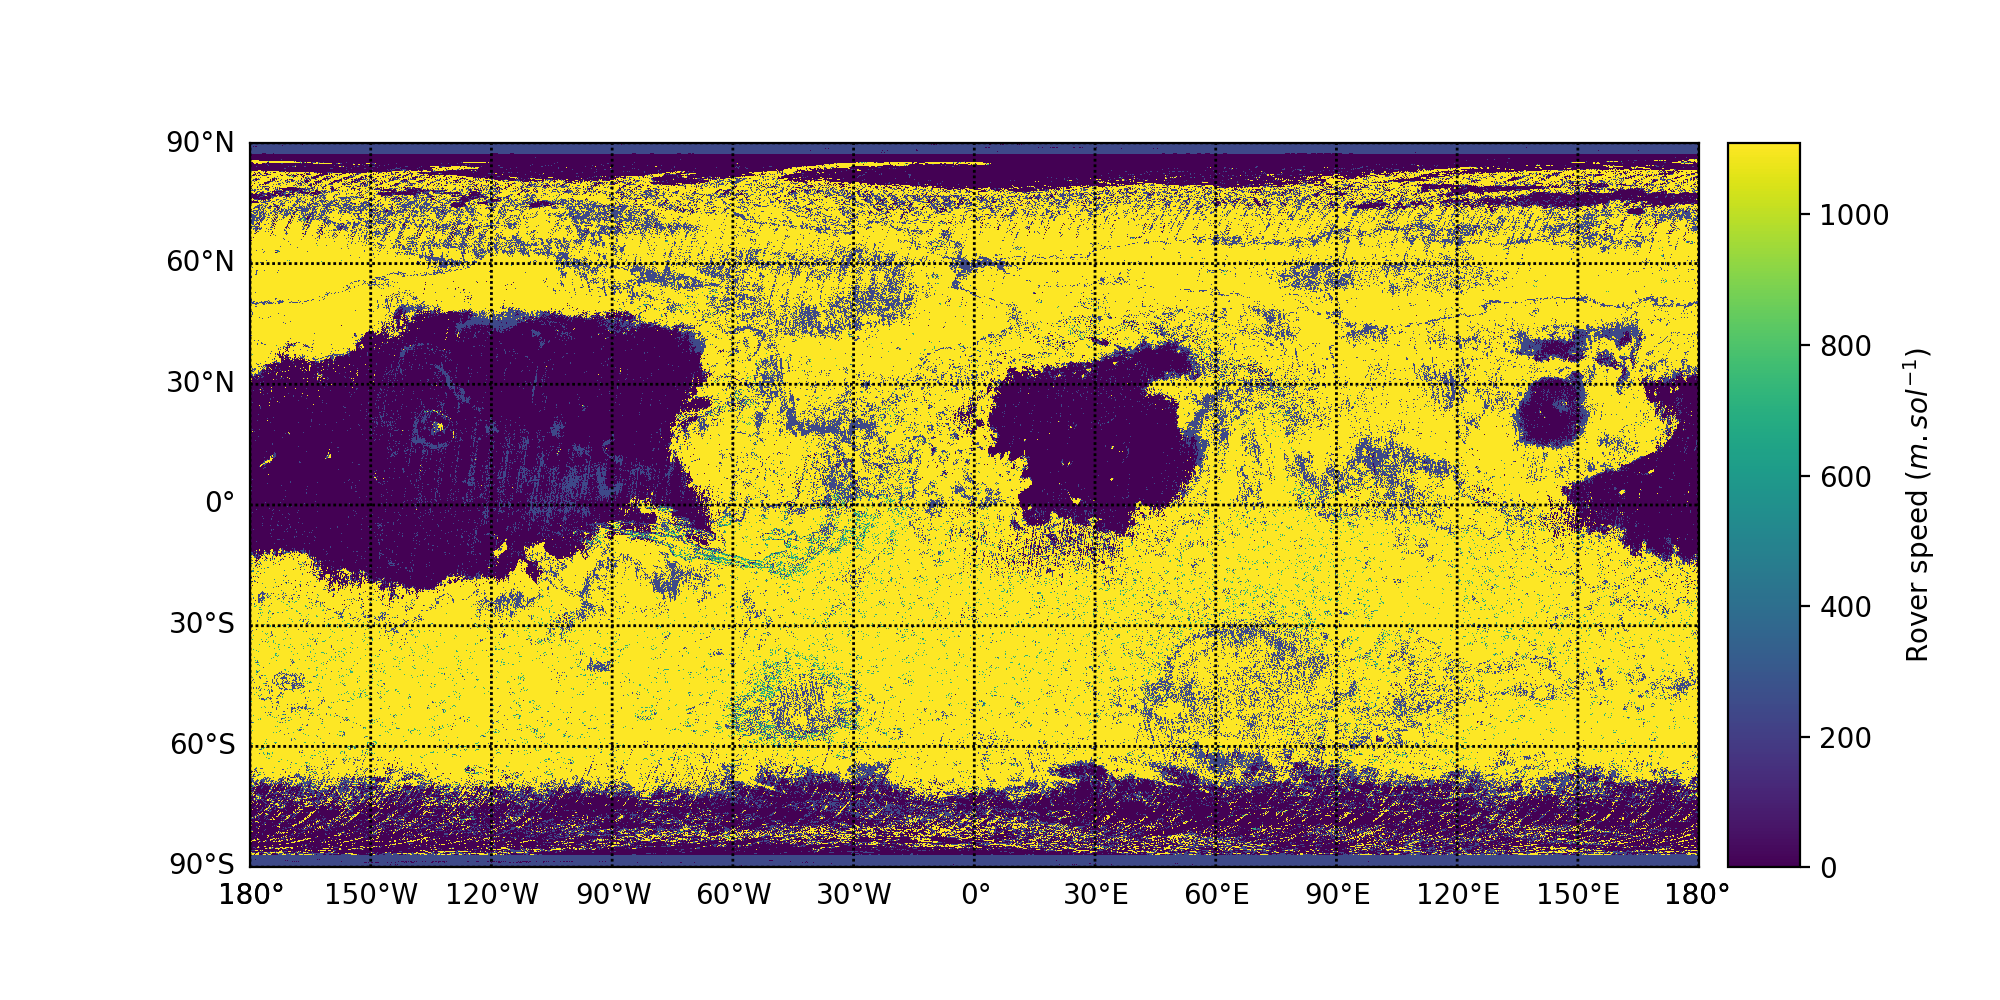

In [7]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rover_speed_array, 'Rover speed ($m.sol^{-1}$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

## Scientific targets

We initialize an array in which we will rasterize all the targets. It will be used to determine the locations of the time constraints at the end of the notebook.

In [8]:
scientific_targets_array = np.ones((master_height, master_width), dtype = np.int)

We load the geological structures from the geological map of Mars only once.

In [9]:
shapefile_structures = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Structure.shp')
print_shapefile_field_names(shapefile_structures)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| OBJECTID | Morphology | Origin | Interpreta | Preservati | Dimension | Shape_Leng | SphLen_km 
\_______________________________________________________________________________


In [10]:
print_shapefile_unique_field_values(shapefile_structures, 'Interpreta')

 _______________________________________________________________________________
/ Interpreta:
| 
| Caldera rim | Channel axis | Crater rim | Graben axis | Lobate flow | Outflow Channel | Pit crater chain | Ridge | Rille | Scarp | Spiral trough | Wrinkle ridge | Yardangs 
\_______________________________________________________________________________


We do the same with the crater database.

In [11]:
mars_craters = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/marscraters.csv',
                                                    longitude_column_index = 2,
                                                    latitude_column_index = 1,
                                                    other_data_column_indexes = [5, 22, 36, 37, 42])

### Hydrous minerals

**Hydrous-mineral exposures**

www.cosmos.esa.int/web/psa/mars-maps

For each target type, we need two steps: Rasterize the initial vector data at 20 ppd and perform the fast marching.

&#9888; Each fast marching takes about ten minutes.

In [12]:
hydrous_mineral_exposures = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/MEX/OMEGA/HYDROUS_SITES_GEO_MAP.CSV')

In [13]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(hydrous_mineral_exposures[0])):
    feature_geometry = Point(hydrous_mineral_exposures[0][i], hydrous_mineral_exposures[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [14]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 50s, sys: 15.3 s, total: 10min 5s
Wall time: 9min 48s


Then, export the map to a .tif file.

In [15]:
data_name = 'Hydrous_Mineral_Exposures'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Chloride exposures**

JMARS

The shapefile is defined between 0 and 360 degree E in longitude, we need to convert it to -180 to 180 degree first.

In [16]:
shapefile_chloride_materials = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/Chloride-bearing-materials_Osterloo-2010.shp')

print_shapefile_field_names(shapefile_chloride_materials)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| Label | DCS_spectr | Lat2 | Lon2 | showlbl | jC_fillclr 
\_______________________________________________________________________________


In [17]:
shapefile_chloride_materials.GetLayer().GetExtent()

(0.4769999744270308, 359.7988281305187, -56.08007755780634, 22.97070311277097)

In [18]:
clip_polygon_0 = Polygon([(0., -90.), (0., 90.), (180., 90.), (180., -90.)])
clip_polygon_180 = Polygon([(180., -90.), (180., 90.), (360., 90.), (360., -90.)])

shapefile_chloride_materials_cliped_0 = clip_shapefile(shapefile_chloride_materials, clip_polygon_0)
shapefile_chloride_materials_cliped_180 = clip_shapefile(shapefile_chloride_materials, clip_polygon_180)

shapefile_chloride_materials_cliped_180 = modify_shapefile_extent(shapefile_chloride_materials_cliped_180, 
                                                                  180., 360., -90., 90., 
                                                                  -180., 0., -90., 90.)
shapefile_chloride_materials = union_shapefiles(shapefile_chloride_materials_cliped_0,
                                                shapefile_chloride_materials_cliped_180)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [19]:
projection = shapefile_chloride_materials.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_chloride_materials, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [20]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 42s, sys: 14.8 s, total: 8min 56s
Wall time: 8min 40s


Export the map to a .tif file.

In [21]:
data_name = 'Chloride_Materials'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Carbonate exposures**

JMARS

We need to extract the carbonate exposure locations from the shapefile, and convert it from 0 to 360 degree E in longitude, to -180 to 180 degree.

In [22]:
shapefile_carbonate_rocks = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/Aqueous-Mineral-Distribution_Ehlmann-Edwards-2014.csv.point.shp')
print_shapefile_field_names(shapefile_carbonate_rocks)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| Feature | jC_lineclr | filled | Name | jC_fillclr | ShowPoints | Show Outli | Point size | lwidth | Class 
\_______________________________________________________________________________


In [23]:
print_shapefile_unique_field_values(shapefile_carbonate_rocks, 'Class')

 _______________________________________________________________________________
/ Class:
| 
| carbonate | chloride | phyllosilicate | silica | sulfate 
\_______________________________________________________________________________


In [24]:
shapefile_carbonate_rocks = filter_shapefile(shapefile_carbonate_rocks,
                                             'Class', 
                                             ['carbonate'])

In [25]:
shapefile_carbonate_rocks.GetLayer().GetExtent()

(45.38999938964844, 336.45001220703125, -20.40999984741211, 64.83999633789062)

In [26]:
clip_polygon_0 = Polygon([(0., -90.), (0., 90.), (180., 90.), (180., -90.)])
clip_polygon_180 = Polygon([(180., -90.), (180., 90.), (360., 90.), (360., -90.)])

shapefile_carbonate_rocks_cliped_0 = clip_shapefile(shapefile_carbonate_rocks, clip_polygon_0)
shapefile_carbonate_rocks_cliped_180 = clip_shapefile(shapefile_carbonate_rocks, clip_polygon_180)

shapefile_carbonate_rocks_cliped_180 = modify_shapefile_extent(shapefile_carbonate_rocks_cliped_180, 
                                                                180., 360., -90., 90., 
                                                                -180., 0., -90., 90.)
shapefile_carbonate_rocks = union_shapefiles(shapefile_carbonate_rocks_cliped_0,
                                             shapefile_carbonate_rocks_cliped_180)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [27]:
projection = shapefile_carbonate_rocks.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_carbonate_rocks, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [28]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 32s, sys: 14.4 s, total: 8min 47s
Wall time: 8min 30s


Export the map to a .tif file.

In [29]:
data_name = 'Carbonate_Rocks'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

### Sedimentary structures

**Sedimentary-rock exposures**

https://isis.astrogeology.usgs.gov/IsisSupport/index.php?topic=2570.0

First, we convert the longitudes to -180 - 180 degree East.

In [30]:
sedimentary_rock_exposures = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/sedrocks_latlong.csv')

In [31]:
for i in range(len(sedimentary_rock_exposures[0])):
    if sedimentary_rock_exposures[0][i] > 180.:
        sedimentary_rock_exposures[0][i] = 360. - sedimentary_rock_exposures[0][i]
    else:
        sedimentary_rock_exposures[0][i] *= -1.

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [32]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(sedimentary_rock_exposures[0])):
    feature_geometry = Point(sedimentary_rock_exposures[0][i], sedimentary_rock_exposures[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [33]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 54s, sys: 13.9 s, total: 9min 8s
Wall time: 8min 53s


Export the map to a .tif file.

In [34]:
data_name = 'Sedimentary_Rock_Exposures'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Valley networks**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/channels/Hynek

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [35]:
shapefile_valley_networks = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/Hynek_VNs/Hynek_Valley_Networks.shp')

print_shapefile_field_names(shapefile_valley_networks)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| tot_length 
\_______________________________________________________________________________


In [36]:
print(shapefile_valley_networks.GetLayer().GetExtent())

raster_topo = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print(get_raster_extent(raster_topo))

(-10669444.875, 10667322.4531, -4248817.0123, 3187641.742799999)
(-10669675.197320545, 10669675.197320545, -5334837.598660273, 5334837.598660273)


In [37]:
x_min, x_max, y_min, y_max = get_raster_extent(raster_topo)

shapefile_valley_networks = modify_shapefile_extent(shapefile_valley_networks, 
                                                    x_min, x_max, y_min, y_max, 
                                                    master_lon_min, master_lon_max, master_lat_min, master_lat_max,
                                                    geom_type = ogr.wkbLineString)

projection = shapefile_valley_networks.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_valley_networks, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [38]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 48s, sys: 16.3 s, total: 10min 5s
Wall time: 9min 46s


Export the map to a .tif file.

In [39]:
data_name = 'Valley_Networks'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Glaciofluvial valleys**

https://planetarydatabase.wordpress.com/2016/04/21/potential-glaciofluvial-valleys-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [40]:
glaciofluvial_valleys = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                      sheetname = 'Glaciofl... (Fassett et al. 201')

In [41]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in glaciofluvial_valleys.iterrows():
    feature_geometry = Point(row['Lon 180'], row['Lat'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [42]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 47s, sys: 15.1 s, total: 9min 2s
Wall time: 8min 44s


Export the map to a .tif file.

In [43]:
data_name = 'Glaciofluvial_Valleys'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-wall channels**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [44]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Channels' in crater[4] or 'Channel' in crater[4] or 'Channsl' in crater[4]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [45]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 11min 11s, sys: 15.8 s, total: 11min 27s
Wall time: 11min 10s


Export the map to a .tif file.

In [46]:
data_name = 'Crater_Wall_Channels'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-floor channels**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [47]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Channels' in crater[5] or 'Channel' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [48]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 13s, sys: 15.4 s, total: 9min 29s
Wall time: 9min 11s


Export the map to a .tif file.

In [49]:
data_name = 'Crater_Floor_Channels'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Alluvial fans**

https://planetarydatabase.wordpress.com/2016/04/21/alluvial-fans-on-mars and Metz et al. (2009)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [50]:
alluvial_fans = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                              sheetname = 'Fan (Moore + Kraal)')
alluvial_fans_part2 = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/Alluvial-Fans_Metz-et-al-2009.csv',
                                                           longitude_column_index = 0, latitude_column_index = 1)

In [51]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in alluvial_fans.iterrows():
    feature_geometry = Point(row['Apex longitude, E 180'], row['Apex latitude'])
    shapes.append(feature_geometry)
for i in range(len(alluvial_fans_part2[0])):
    feature_geometry = Point(alluvial_fans_part2[0][i], alluvial_fans_part2[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [52]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 39s, sys: 11.3 s, total: 9min 50s
Wall time: 9min 38s


Export the map to a .tif file.

In [53]:
data_name = 'Alluvial_Fans'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Deltaic deposits**

https://planetarydatabase.wordpress.com/2016/04/21/deltaic-deposits-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [54]:
deltaic_deposits = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                 sheetname = 'Delta (di Achille.. 2010)')

In [55]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in deltaic_deposits.iterrows():
    feature_geometry = Point(row['Lon E 180'], row['Lat'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [56]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 10min 19s, sys: 15.4 s, total: 10min 35s
Wall time: 10min 18s


Export the map to a .tif file.

In [57]:
data_name = 'Deltaic_Deposits'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Young deltas**

Hauber et al. (2013)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [58]:
young_deltas = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/Young-Deltas_Hauber-et-al-2013.csv',
                                                    longitude_column_index = 4, latitude_column_index = 2)

In [59]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(young_deltas[0])):
    feature_geometry = Point(young_deltas[0][i], young_deltas[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [60]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 44s, sys: 16.1 s, total: 9min
Wall time: 8min 41s


Export the map to a .tif file.

In [61]:
data_name = 'Young_Deltas'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Subaqueous fans**

Metz et al. (2009)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [62]:
subaqueous_fans = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/Sublacustrine-Fans_Metz-et-al-2009.csv',
                                                       longitude_column_index = 0, latitude_column_index = 1)

In [63]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(subaqueous_fans[0])):
    feature_geometry = Point(subaqueous_fans[0][i], subaqueous_fans[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [64]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 27s, sys: 13.6 s, total: 8min 40s
Wall time: 8min 24s


Export the map to a .tif file.

In [65]:
data_name = 'Subaqueous_Fans'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-floor valley deposits**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [66]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Valley Deposits' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [67]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 8s, sys: 15.5 s, total: 9min 24s
Wall time: 9min 6s


Export the map to a .tif file.

In [68]:
data_name = 'Crater_Floor_Valley_Deposits'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Open-basin lakes**

https://planetarydatabase.wordpress.com/2016/04/21/open-basin-lakes-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [69]:
open_basin_lakes = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                 sheetname = 'Open basin (Goudge et al. 2012)')

In [70]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in open_basin_lakes.iterrows():
    feature_geometry = Point(row['Lon_E 180'], row['Lat_N'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [71]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 40s, sys: 9.94 s, total: 9min 50s
Wall time: 9min 40s


Export the map to a .tif file.

In [72]:
data_name = 'Open_Basin_Lakes'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Impact crater-hosted closed-basin lakes**

https://planetarydatabase.wordpress.com/2016/04/21/candidate-impact-crater-hosted-closed-basin-lakes-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [73]:
closed_basin_lakes = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                   sheetname = 'Closed basin (Goudge et al2015)')

In [74]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in closed_basin_lakes.iterrows():
    feature_geometry = Point(row['Lon E 180'], row['Lat (N)'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [75]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 17s, sys: 14.6 s, total: 9min 32s
Wall time: 9min 15s


Export the map to a .tif file.

In [76]:
data_name = 'Closed_Basin_Lakes'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Channels not interpreted as valley networks**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

We first intersect the channels from the geological maps of Mars with the valley networks, to avoid redundancy, and because the valley networks were interpreted from higher-resolution data.

In [77]:
shapefile_valley_networks = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/Hynek_VNs/Hynek_Valley_Networks.shp')

print_shapefile_field_names(shapefile_valley_networks)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| tot_length 
\_______________________________________________________________________________


In [78]:
raster_topo = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
x_min, x_max, y_min, y_max = get_raster_extent(raster_topo)

shapefile_valley_networks = modify_shapefile_extent(shapefile_valley_networks, 
                                                    x_min, x_max, y_min, y_max, 
                                                    master_lon_min, master_lon_max, master_lat_min, master_lat_max,
                                                    geom_type = ogr.wkbLineString)

In [79]:
shapefile_valley_networks = buffer_shapefile(shapefile_valley_networks, 0.001)

In [80]:
shapefile_channels = filter_shapefile(shapefile_structures,
                                      'Interpreta', 
                                      ['Channel axis'])
print_shapefile_field_names(shapefile_channels)

shapefile_channels_part2 = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/NPlains_geology_SIM2888_2005/SIM2888_mar06_preliminary/shapefiles/SIM2888_Mars2000_Sphere/SIM2888_channels_ocentric.shp')
print_shapefile_field_names(shapefile_channels_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| Shape_Leng 
\_______________________________________________________________________________


In [81]:
%%time

shapefile_channels = get_intersected_features_from_shapefile(shapefile_channels,
                                                             shapefile_valley_networks,
                                                             look_for_intersection = False)

shapefile_channels_part2 = get_intersected_features_from_shapefile(shapefile_channels_part2,
                                                                   shapefile_valley_networks,
                                                                   look_for_intersection = False)

CPU times: user 2min 52s, sys: 68.3 ms, total: 2min 52s
Wall time: 2min 52s


Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [82]:
projection = shapefile_channels.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_channels, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

projection = shapefile_channels_part2.GetLayer().GetSpatialRef().ExportToWkt()

raster_rasterization_part2 = rasterize_shapefile(shapefile_channels_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 0] = 0

scientific_targets_array[raster_rasterization_array == 0] = 0

In [83]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 5s, sys: 13.9 s, total: 9min 19s
Wall time: 9min 3s


Export the map to a .tif file.

In [84]:
data_name = 'Channels_Not_Valleys'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Outflow channels**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [85]:
shapefile_outflow_channels = filter_shapefile(shapefile_structures,
                                              'Interpreta', 
                                              ['Outflow Channel'])
print_shapefile_field_names(shapefile_outflow_channels)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [86]:
projection = shapefile_outflow_channels.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_outflow_channels, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [87]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 30s, sys: 13.9 s, total: 8min 44s
Wall time: 8min 28s


Export the map to a .tif file.

In [88]:
data_name = 'Outflow_Channels'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Outflow channels and large valleys**

Irwin and Grant (2009)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [89]:
outflow_channels_large_valleys = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/Outflow-Channels-Large-Valleys_Irwin-Grant-2009.csv',
                                                                      longitude_column_index = 0, latitude_column_index = 1)

In [90]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(outflow_channels_large_valleys[0])):
    feature_geometry = Point(outflow_channels_large_valleys[0][i], outflow_channels_large_valleys[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [91]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 44s, sys: 15.2 s, total: 8min 59s
Wall time: 8min 41s


Export the map to a .tif file.

In [92]:
data_name = 'Outflow_Channels_Large_Valleys'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Groundwater-controlled valley networks**

https://planetarydatabase.wordpress.com/2016/04/21/groundwater-controlled-valley-networks-large-sparsely-dissecting-valley-networks-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [93]:
groundwater_valley_networks = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                            sheetname = 'Sparse valley Harrison Grimm 20')

In [94]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in groundwater_valley_networks.iterrows():
    feature_geometry = Point(row['Lon E 180'], row['Lat'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [95]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 53s, sys: 15.2 s, total: 10min 8s
Wall time: 9min 51s


Export the map to a .tif file.

In [96]:
data_name = 'Groundwater_Valley_Networks'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Craters with sandbars**

https://planetarydatabase.wordpress.com/2016/04/21/craters-with-sandbars/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [97]:
craters_sandbars = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                 sheetname = 'CratersSandbars (Robbins..2012)')

In [98]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in craters_sandbars.iterrows():
    feature_geometry = Point(row['LONGITUDE_ 180'], row['LATITUDE_C'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [99]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 31s, sys: 16.4 s, total: 8min 48s
Wall time: 8min 29s


Export the map to a .tif file.

In [100]:
data_name = 'Craters_Sandbars'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-floor landslide deposits**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [101]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Landslide Deposits' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [102]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 5s, sys: 15.2 s, total: 9min 21s
Wall time: 9min 3s


Export the map to a .tif file.

In [103]:
data_name = 'Crater_Floor_Landslide_Deposits'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Gullies**

https://planetarydatabase.wordpress.com/2016/04/21/gullied-landforms-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [104]:
gullies = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                        sheetname = 'Gully (Harrison et al. 2015)')

In [105]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in gullies.iterrows():
    feature_geometry = Point(row['longitude 180'], row['latitude'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [106]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 50s, sys: 13.3 s, total: 10min 3s
Wall time: 9min 49s


Export the map to a .tif file.

In [107]:
data_name = 'Gullies'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Recurring Slope Lineae**

https://planetarydatabase.wordpress.com/2016/04/21/recurring-slope-lineae-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [108]:
rsl = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                    sheetname = 'RSL (OjhaMcEwenStillman)')

In [109]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in rsl.iterrows():
    feature_geometry = Point(row['Lon E 180'], row['Lat'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [110]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 50s, sys: 9.97 s, total: 9min
Wall time: 8min 48s


Export the map to a .tif file.

In [111]:
data_name = 'RSL'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Slope streaks**

https://planetarydatabase.wordpress.com/2016/04/21/slope-streaks-bright-and-dark-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [112]:
slope_streaks = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                              sheetname = 'SlopeStreak (Schorghofer..2007)')

In [113]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in slope_streaks.iterrows():
    if pd.isnull(row['MOC NA image ID']) == False:
        feature_geometry = Point(row['Lon E 180'], row['Lat planetographic !'])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [114]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 37s, sys: 11.4 s, total: 8min 49s
Wall time: 8min 35s


Export the map to a .tif file.

In [115]:
data_name = 'Slope_Streaks'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Glacial features**

https://planetarydatabase.wordpress.com/2016/04/21/first-blog-post

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [116]:
shapefile_glacial_features = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/glacial features/AreaIceUnits.shp')

print_shapefile_field_names(shapefile_glacial_features)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| code 
\_______________________________________________________________________________


In [117]:
print(shapefile_glacial_features.GetLayer().GetExtent())

raster_topo = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print(get_raster_extent(raster_topo))

(-10668777.765116848, 10666342.399609, -3390990.841498883, 3889734.7697941484)
(-10669675.197320545, 10669675.197320545, -5334837.598660273, 5334837.598660273)


In [118]:
x_min, x_max, y_min, y_max = get_raster_extent(raster_topo)

shapefile_glacial_features = modify_shapefile_extent(shapefile_glacial_features, 
                                                     x_min, x_max, y_min, y_max, 
                                                     master_lon_min, master_lon_max, master_lat_min, master_lat_max)
print(shapefile_glacial_features.GetLayer().GetExtent())

projection = shapefile_glacial_features.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_glacial_features, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

(-10337000.766550215, 10320277.366507426, -2614890.368206277, 2918187.2967245)


In [119]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 34s, sys: 11.9 s, total: 9min 46s
Wall time: 9min 32s


Export the map to a .tif file.

In [120]:
data_name = 'Glacial_Features'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Glacier-like forms**

https://planetarydatabase.wordpress.com/2016/04/21/glacier-like-forms

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [121]:
glacier_like_forms = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                   sheetname = 'GLF Souness et al. 2012')

In [122]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in glacier_like_forms.iterrows():
    if pd.isnull(row['Centre lon. (deg. East)']) == False:
        longitude = float(row['Centre lon. (deg. East)'])
        if longitude > 180.:
            longitude -= 360.
        feature_geometry = Point(longitude, float(row['Centre .Lat']))
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [123]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 1s, sys: 11.4 s, total: 9min 12s
Wall time: 8min 59s


Export the map to a .tif file.

In [124]:
data_name = 'Glacier_like_Forms'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crevassed glacier-like forms**

https://planetarydatabase.wordpress.com/2016/04/21/crevassed-glacier-like-forms-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [125]:
crevassed_glacier_like_forms = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                             sheetname = 'CrevassedGLF (Hubbard et al. 20')

In [126]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in crevassed_glacier_like_forms.iterrows():
    feature_geometry = Point(float(row['Lon 180 E centre']), float(row['Centre .Lat']))
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [127]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 53s, sys: 11.1 s, total: 9min 4s
Wall time: 8min 51s


Export the map to a .tif file.

In [128]:
data_name = 'Crevassed_Glacier_like_Forms'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Recessional glacier-like forms**

https://planetarydatabase.wordpress.com/2016/04/26/recessional-glacier-like-forms

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [129]:
recessional_glacier_like_forms = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                               sheetname = 'Recessional GLF')

In [130]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in recessional_glacier_like_forms.iterrows():
    feature_geometry = Point(float(row['Centre lon. (deg. east) 180']), float(row['Centre lat.']))
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [131]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 53s, sys: 10.7 s, total: 9min 3s
Wall time: 8min 51s


Export the map to a .tif file.

In [132]:
data_name = 'Recessional_Glacier_like_Forms'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Tropical mountain glaciers**

https://planetarydatabase.wordpress.com/2016/04/21/fan-shaped-deposits-interpeted-as-tropical-mountain-glaciers-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [133]:
tropical_mountain_glaciers = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                           sheetname = 'TropGlac (Kadish et al. 2014)')

In [134]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in tropical_mountain_glaciers.iterrows():
    feature_geometry = Point(row['Lon E 180'], row['Lat'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [135]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 626 ms, sys: 145 ms, total: 771 ms
Wall time: 769 ms


Export the map to a .tif file.

In [136]:
data_name = 'Tropical_Mountain_Glaciers'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Dissected mantle**

https://planetarydatabase.wordpress.com/2016/07/05/dissected-mantle-ldm

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [137]:
dissected_mantle = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                                 sheetname = 'Dissected mantle Milliken')

In [138]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in dissected_mantle.iterrows():
    feature_geometry = Point(row['center lon (east)'], row['center lat.'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [139]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 27s, sys: 12.6 s, total: 9min 40s
Wall time: 9min 25s


Export the map to a .tif file.

In [140]:
data_name = 'Dissected_Mantle'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Dune fields**

https://planetarydatabase.wordpress.com/2016/04/21/mars-global-digital-dune-database

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [141]:
shapefile_dune_fields = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/dune-polygon/dune-polygon.shp')

print_shapefile_field_names(shapefile_dune_fields)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| OBJECTID | Dune_Lon | Dune_Lat | Dune_ID | In_origina | Dune_Type | B_1 | Bd_1 | D_1 | L_1 | S_1 | SS_1 | T_1 | U_1 | BullsEye | Confidence | Type_Image | Area_sinu_ | SF | MDH1 | Volume_1 | MDH2 | Volume_2 | Avg_El | CcDcAz_Geo | CcDcAz_Mer | CcDcAz_Ste | SF_1_Az | SF_1_Count | SF_2_Az | SF_2_Count | SF_3_Az | SF_3_Count | SF_4_Az | SF_4_Count | Environ | Cr_Lon | Cr_Lat | Crater_BID | Cr_Area_si | Cr_Diam | MC | THEMIS_IR | THEMIS_VIS | MOC_NA | CTX | HiRISE | HRSC | WEB_LINK_1 | WEB_LINK_2 | Comments | SF1_Merc | SF2_Merc | SF3_Merc | SF4_Merc | Shape_Leng | MDHeight | CcDcAzimut | SF_2_Azimu | SF_3_Azimu | SF_4_Azimu | Cr_Lon_Eas | Cr_Diam_1 | Mars_5M_Ch | VIS | MOC | Comments_1 | Density | IR | Shape_Le_1 | Shape_Area 
\_______________________________________________________________________________


In [142]:
projection = shapefile_dune_fields.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_dune_fields, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [143]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 23s, sys: 10.6 s, total: 9min 33s
Wall time: 9min 21s


Export the map to a .tif file.

In [144]:
data_name = 'Dune_Fields'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-floor dunes**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [145]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Dunes' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [146]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 40s, sys: 12 s, total: 9min 52s
Wall time: 9min 38s


Export the map to a .tif file.

In [147]:
data_name = 'Crater_Floor_Dunes'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Yardangs**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [148]:
shapefile_yardangs = filter_shapefile(shapefile_structures,
                                      'Interpreta', 
                                      ['Yardangs'])
print_shapefile_field_names(shapefile_yardangs)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [149]:
projection = shapefile_yardangs.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_yardangs, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [150]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 27s, sys: 10.3 s, total: 8min 38s
Wall time: 8min 25s


Export the map to a .tif file.

In [151]:
data_name = 'Yardangs'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

### Volcanic, tectonic, and impact structures

**Volcanoes**

https://planetarydatabase.wordpress.com/category/mars/volcanoes

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [152]:
shapefile_volcanoes = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/volcano/volcano0610.shp')

print_shapefile_field_names(shapefile_volcanoes)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| Name | Peri | Dia | Area | Reference | Name2 | Type | Group | EdificeA | EdificeB | Source | TypeHodges | Lat | Lon180E | Img | MAX_1 | RANGE_1 | MEAN 
\_______________________________________________________________________________


In [153]:
print(shapefile_volcanoes.GetLayer().GetExtent())

raster_topo = open_raster(base_folder + 'Original_Data/MGS/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m.tif')
print(get_raster_extent(raster_topo))

(-10384158.801737586, 10665646.435884062, -4497441.616826917, 4820504.397432575)
(-10669675.197320545, 10669675.197320545, -5334837.598660273, 5334837.598660273)


In [154]:
x_min, x_max, y_min, y_max = get_raster_extent(raster_topo)

shapefile_volcanoes = modify_shapefile_extent(shapefile_volcanoes, 
                                              x_min, x_max, y_min, y_max, 
                                              master_lon_min, master_lon_max, master_lat_min, master_lat_max)

projection = shapefile_volcanoes.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_volcanoes, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [155]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 17s, sys: 11.3 s, total: 9min 28s
Wall time: 9min 15s


Export the map to a .tif file.

In [156]:
data_name = 'Volcanoes'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Calderas**

https://planetarydatabase.wordpress.com/2016/04/21/calderas/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [157]:
shapefile_calderas = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/caldera3/calderas_3.shp')

print_shapefile_field_names(shapefile_calderas)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| OBJECTID | LON | LAT_1 | Area | Name | Source | Caledra_No 
\_______________________________________________________________________________


In [158]:
projection = shapefile_calderas.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_calderas, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [159]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 37s, sys: 11.1 s, total: 8min 48s
Wall time: 8min 35s


Export the map to a .tif file.

In [160]:
data_name = 'Calderas'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Tharsis vents**

astrogeology.usgs.gov/search/map/Mars/Research/Volcanic/TharsisVents

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [161]:
shapefile_tharsis_vents = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/TharsisVents140408/TharsisVents140408_dd0.shp')

print_shapefile_field_names(shapefile_tharsis_vents)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| Longitude | Latitude 
\_______________________________________________________________________________


In [162]:
projection = shapefile_tharsis_vents.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_tharsis_vents, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [163]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 23s, sys: 10.2 s, total: 8min 33s
Wall time: 8min 21s


Export the map to a .tif file.

In [164]:
data_name = 'Tharsis_Vents'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Rilles**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [165]:
shapefile_rilles = filter_shapefile(shapefile_structures,
                                    'Interpreta', 
                                    ['Rille'])
print_shapefile_field_names(shapefile_rilles)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [166]:
projection = shapefile_rilles.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_rilles, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [167]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 34s, sys: 11.4 s, total: 8min 46s
Wall time: 8min 33s


Export the map to a .tif file.

In [168]:
data_name = 'Rilles'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Lobate flows**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [169]:
shapefile_lobate_flows = filter_shapefile(shapefile_structures,
                                          'Interpreta', 
                                          ['Lobate flow'])
print_shapefile_field_names(shapefile_lobate_flows)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [170]:
projection = shapefile_lobate_flows.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_lobate_flows, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [171]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 41s, sys: 12.4 s, total: 8min 53s
Wall time: 8min 39s


Export the map to a .tif file.

In [172]:
data_name = 'Lobate_Flows'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Graben axes**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [173]:
shapefile_graben_axes = filter_shapefile(shapefile_structures,
                                         'Interpreta', 
                                         ['Graben axis'])
print_shapefile_field_names(shapefile_graben_axes)

shapefile_graben_axes_part2 = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/NPlains_geology_SIM2888_2005/SIM2888_mar06_preliminary/shapefiles/SIM2888_Mars2000_Sphere/SIM2888_grabens_ocentric.shp')
print_shapefile_field_names(shapefile_graben_axes_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| TYPE | Shape_Leng 
\_______________________________________________________________________________


In [174]:
projection = shapefile_graben_axes.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_graben_axes, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

projection = shapefile_graben_axes_part2.GetLayer().GetSpatialRef().ExportToWkt()

raster_rasterization_part2 = rasterize_shapefile(shapefile_graben_axes_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 0] = 0

scientific_targets_array[raster_rasterization_array == 0] = 0

In [175]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 38s, sys: 11.4 s, total: 9min 49s
Wall time: 9min 36s


Export the map to a .tif file.

In [176]:
data_name = 'Graben_Axes'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Pit-crater chain**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [177]:
shapefile_pit_crater_chains = filter_shapefile(shapefile_structures,
                                               'Interpreta', 
                                               ['Pit crater chain'])
print_shapefile_field_names(shapefile_pit_crater_chains)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [178]:
projection = shapefile_pit_crater_chains.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_pit_crater_chains, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [179]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 32s, sys: 11 s, total: 8min 43s
Wall time: 8min 30s


Export the map to a .tif file.

In [180]:
data_name = 'Pit_crater_Chains'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Wrinkle ridges**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [181]:
shapefile_wrinkle_ridges = filter_shapefile(shapefile_structures,
                                            'Interpreta', 
                                            ['Wrinkle ridge'])
print_shapefile_field_names(shapefile_wrinkle_ridges)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [182]:
projection = shapefile_wrinkle_ridges.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_wrinkle_ridges, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [183]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 10min 4s, sys: 12 s, total: 10min 16s
Wall time: 10min 3s


Export the map to a .tif file.

In [184]:
data_name = 'Wrinkle_Ridges'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Crater-floor tectonics**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [185]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Tectonics' in crater[5] or 'tectonics' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [186]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 48s, sys: 12.4 s, total: 10min
Wall time: 9min 46s


Export the map to a .tif file.

In [187]:
data_name = 'Crater_Floor_Tectonics'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Fractured crater floors**

http://craters.sjrdesign.net/

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [188]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if 'Fractured' in crater[5]:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [189]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 18s, sys: 11.2 s, total: 9min 30s
Wall time: 9min 17s


Export the map to a .tif file.

In [190]:
data_name = 'Crater_Floor_Fractured'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Recent craters**

https://planetarydatabase.wordpress.com/2016/04/21/fresh-craters-on-mars

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [191]:
recent_craters = pd.read_excel(base_folder + 'Original_Data/Interpreted_Data/idpf-9-23-2016-excel97.xls',
                               sheetname = 'Fresh craters (Daubar 2014-16)')

In [192]:
data_type = gdal.GDT_Int32

shapes = []
for index, row in recent_craters.iterrows():
    feature_geometry = Point(row['Longtude E 180'], row['Latitude (planetocentric)'])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [193]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 41s, sys: 11.3 s, total: 8min 53s
Wall time: 8min 40s


Export the map to a .tif file.

In [194]:
data_name = 'Recent_Craters'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Fresh craters**

http://craters.sjrdesign.net/

Degradation state = 4

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [195]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if float(crater[6]) == 4:
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [196]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 10min 46s, sys: 11.5 s, total: 10min 57s
Wall time: 10min 44s


Export the map to a .tif file.

In [197]:
data_name = 'Fresh_Craters'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Deep craters**

http://craters.sjrdesign.net/

Depth > 2 km

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [198]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if float(crater[3]) > 2.: # kilometers
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [199]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 40s, sys: 11.7 s, total: 9min 52s
Wall time: 9min 38s


Export the map to a .tif file.

In [200]:
data_name = 'Deep_Craters'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Large degraded craters**

http://craters.sjrdesign.net/

Diameter &ge; 10 km & degradation state = 1 or 2

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [201]:
data_type = gdal.GDT_Int32

shapes = []
for crater in zip(*mars_craters):
    if float(crater[2]) >= 10. and (float(crater[6]) == 1 or float(crater[6]) == 2): # kilometers
        feature_geometry = Point(crater[0], crater[1])
        shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [202]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 11min 28s, sys: 12.7 s, total: 11min 41s
Wall time: 11min 27s


Export the map to a .tif file.

In [203]:
data_name = 'Large_Degraded_Craters'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Potential hydrothermal systems**

Farmer (1996); Dohm et al., (2000); Marzo et al. (2010)

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [204]:
potential_hydrothermal_systems = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Interpreted_Data/Potential-Hydrothermal-Systems_Farmer-1996-And-Others.csv')

In [205]:
data_type = gdal.GDT_Int32

shapes = []
for i in range(len(potential_hydrothermal_systems[0])):
    feature_geometry = Point(potential_hydrothermal_systems[0][i], potential_hydrothermal_systems[1][i])
    shapes.append(feature_geometry)

raster_rasterization = rasterize_geometries(shapes, 
                                            data_type,
                                            master_width, 
                                            master_height,
                                            master_geotransform,
                                            master_spatial_reference_system)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [206]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 28s, sys: 10.7 s, total: 8min 39s
Wall time: 8min 26s


Export the map to a .tif file.

In [207]:
data_name = 'Potential_Hydrothermal_Systems'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

### Structures with multiple potential origins

**Scarps**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [208]:
shapefile_scarps = filter_shapefile(shapefile_structures,
                                               'Interpreta', 
                                               ['Scarp'])
print_shapefile_field_names(shapefile_scarps)

shapefile_scarps_part2 = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/NPlains_geology_SIM2888_2005/SIM2888_mar06_preliminary/shapefiles/SIM2888_Mars2000_Sphere/SIM2888_scarps_ocentric.shp')
print_shapefile_field_names(shapefile_scarps_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| TYPE | Shape_Leng 
\_______________________________________________________________________________


In [209]:
projection = shapefile_scarps.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_scarps, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

projection = shapefile_scarps_part2.GetLayer().GetSpatialRef().ExportToWkt()

raster_rasterization_part2 = rasterize_shapefile(shapefile_scarps_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 0] = 0

scientific_targets_array[raster_rasterization_array == 0] = 0

In [210]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 10min 24s, sys: 12.2 s, total: 10min 36s
Wall time: 10min 22s


Export the map to a .tif file.

In [211]:
data_name = 'Scarps'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Ridges**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [212]:
shapefile_ridges = filter_shapefile(shapefile_structures,
                                               'Interpreta', 
                                               ['Ridge'])
print_shapefile_field_names(shapefile_ridges)

shapefile_ridges_part2 = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/NPlains_geology_SIM2888_2005/SIM2888_mar06_preliminary/shapefiles/SIM2888_Mars2000_Sphere/SIM2888_ridges_ocentric.shp')
print_shapefile_field_names(shapefile_ridges_part2)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 
| TYPE | Shape_Leng 
\_______________________________________________________________________________


In [213]:
projection = shapefile_ridges.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_ridges, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

projection = shapefile_ridges_part2.GetLayer().GetSpatialRef().ExportToWkt()

raster_rasterization_part2 = rasterize_shapefile(shapefile_ridges_part2, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[raster_rasterization_part2_array == 0] = 0

scientific_targets_array[raster_rasterization_array == 0] = 0

In [214]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 55s, sys: 11.4 s, total: 10min 6s
Wall time: 9min 53s


Export the map to a .tif file.

In [215]:
data_name = 'Ridges'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Polygonal ridge networks**

https://planetarydatabase.wordpress.com/2016/09/23/polygonal-ridges-boxwork-or-reticulate-ridges

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [216]:
shapefile_poly_ridge_networks = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/polygonal_ridge/kerber_ridges.shp')

print_shapefile_field_names(shapefile_poly_ridge_networks)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| Longitude | Latitude | Type | Area 
\_______________________________________________________________________________


In [217]:
projection = shapefile_poly_ridge_networks.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_poly_ridge_networks, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

scientific_targets_array[raster_rasterization_array == 0] = 0

In [218]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 35s, sys: 10.7 s, total: 8min 45s
Wall time: 8min 33s


Export the map to a .tif file.

In [219]:
data_name = 'Polygonal_Ridge_Networks'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

### Time constraints

We use crater-dated geological units of Mars as time constraints. Due to their extent, they contain many cells, and rasterizing them directly increases a lot the computation time of the next steps. So, we only use as time constraints the cells where other targets are present.

<IPython.core.display.Javascript object>


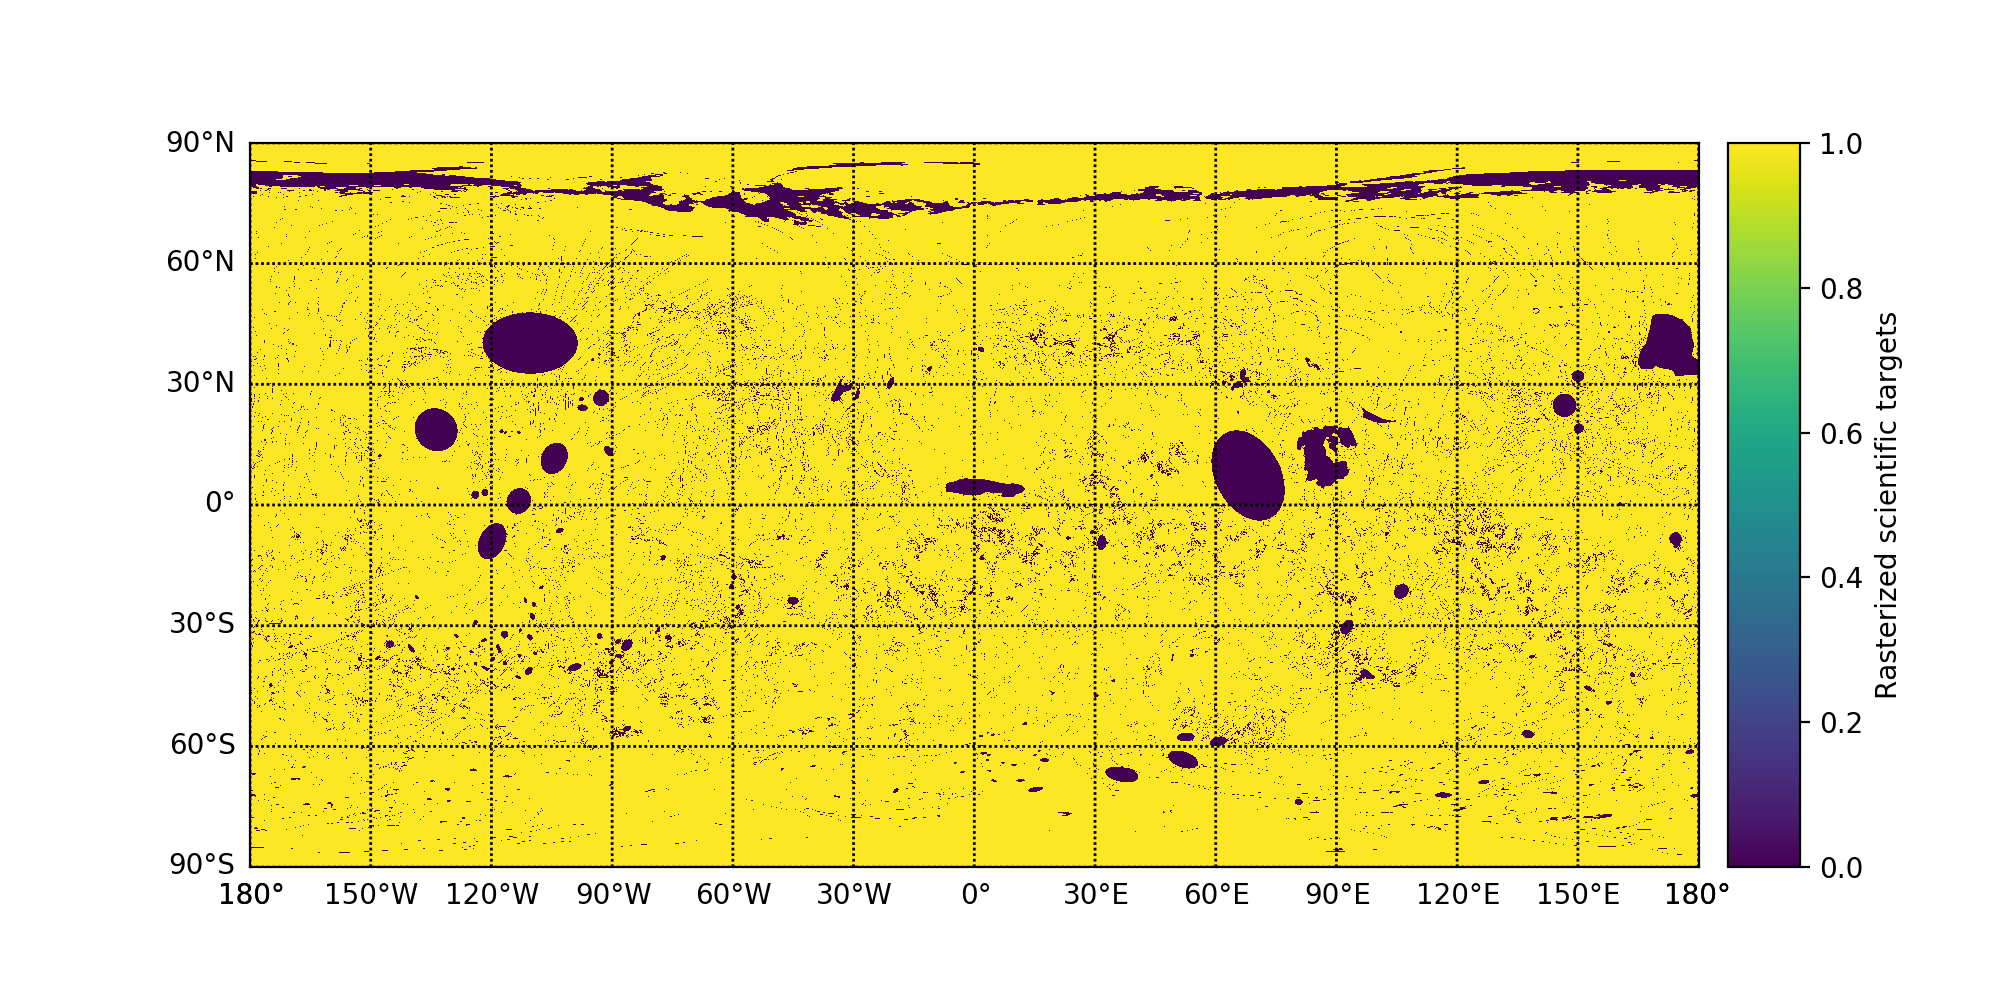

In [220]:
figure1 = plt.figure(figsize = (10, 5))
subfigure1 = figure1.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, scientific_targets_array, 'Rasterized scientific targets')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

We load the geological units from the geological map of Mars only once.

In [221]:
shapefile_geology = open_shapefile(base_folder + 'Original_Data/Interpreted_Data/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Geology.shp')
print_shapefile_field_names(shapefile_geology)

 _______________________________________________________________________________
/ Shapefile field names:
| 
| OBJECTID | Shape_Leng | Shape_Area | Unit | UnitDesc | SphArea_km 
\_______________________________________________________________________________


In [222]:
print_shapefile_unique_field_values(shapefile_geology, 'Unit')

 _______________________________________________________________________________
/ Unit:
| 
| AHi | AHtu | AHv | ANa | Aa | Ap | Apu | Av | Ave | HNb | HNhu | HNt | Hp | Hpe | Hpu | Ht | Hto | Htu | Hve | Nhe | Nhu | Nve | eAb | eHb | eHh | eHt | eHv | eNh | eNhm | lAa | lApc | lApd | lAv | lAvf | lHb | lHl | lHt | lHv | lHvf | lNh | lNv | mAl | mNh | mNhm 
\_______________________________________________________________________________


**Noachian-Hesperian contacts**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

Hesperian: lHl, AHi, Hp, Hpu, Hpe, eHb, lHb, eHv, lHv, lHvf, AHv, Hve, AHtu, Htu, lHt, eHt, Ht, Hto, eHh  
Noachian: lNv, Nve, Nhu, eNh, mNh, lNh, Nhe, eNhm, mNhm  
Noachian and Hesperian units: HNb, ANa, HNt, HNhu  

We have to extract the contact between Hesperian and Noachian units.

In [223]:
shapefile_hesperian_units = filter_shapefile(shapefile_geology,
                                             'Unit', 
                                             ['lHl', 'AHi', 'Hp', 'Hpu', 'Hpe', 'eHb', 'lHb', 'eHv', 'lHv', 'lHvf',
                                              'AHv', 'Hve', 'AHtu', 'Htu', 'lHt', 'eHt', 'Ht', 'Hto', 'eHh'])
shapefile_noachian_units = filter_shapefile(shapefile_geology,
                                            'Unit', 
                                            ['lNv', 'Nve', 'Nhu', 'eNh', 'mNh', 'lNh', 'Nhe', 'eNhm', 'mNhm'])

In [224]:
shapefile_hesperian_borders = get_shapefile_borders(shapefile_hesperian_units)
shapefile_hesperian_borders = buffer_shapefile(shapefile_hesperian_borders, 1e-8)
shapefile_noachian_borders = get_shapefile_borders(shapefile_noachian_units)

In [225]:
shapefile_hesperian_noachian_contacts = intersect_shapefiles(shapefile_hesperian_borders, 
                                                             shapefile_noachian_borders,
                                                             geom_type = ogr.wkbLineString)
shapefile_hesperian_noachian_units = filter_shapefile(shapefile_geology,
                                                      'Unit', 
                                                      ['HNb', 'ANa', 'HNt', 'HNhu'])

print_shapefile_field_names(shapefile_hesperian_noachian_contacts)
print_shapefile_field_names(shapefile_hesperian_noachian_units)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________
 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [226]:
projection = shapefile_hesperian_noachian_contacts.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_hesperian_noachian_contacts, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

projection = shapefile_hesperian_noachian_units.GetLayer().GetSpatialRef().ExportToWkt()

raster_rasterization_part2 = rasterize_shapefile(shapefile_hesperian_noachian_units, 
                                                 None,
                                                 data_type,
                                                 master_width, 
                                                 master_height,                    
                                                 master_geotransform, 
                                                 projection)
raster_rasterization_part2_array = get_raster_array(raster_rasterization_part2)

raster_rasterization_array[(raster_rasterization_part2_array == 0) & (scientific_targets_array == 0)] = 0

In [227]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 53s, sys: 12.3 s, total: 10min 6s
Wall time: 9min 51s


Export the map to a .tif file.

In [228]:
data_name = 'Hesperian_Noachian_Contacts_Targets_Units'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Early to Middle Noachian units**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

eNh, mNh, eNhm, mNhm

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [229]:
shapefile_early_middle_noachian_units = filter_shapefile(shapefile_geology,
                                                         'Unit', 
                                                         ['eNh', 'mNh', 'eNhm', 'mNhm'])
print_shapefile_field_names(shapefile_early_middle_noachian_units)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [230]:
projection = shapefile_early_middle_noachian_units.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_early_middle_noachian_units, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

raster_rasterization_array[scientific_targets_array == 1] = 1

In [231]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 10min 8s, sys: 11.7 s, total: 10min 20s
Wall time: 10min 7s


Export the map to a .tif file.

In [232]:
data_name = 'Early_Middle_Noachian_Targets_Units'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

## Volcanic units

We use the volcanic units to counterbalance the absence of large-scale outcrop study of magmatic rocks. But similarly to the time constraints, the units can have a large extent without necessary implying an outcrop of interest. Thus, we do the same intersection with all the other targets.

**Amazonian to Hesperian volcanic units**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

lAv, lHv, eHv, lAvf, Av, lHvf, AHv, Hve, Ave

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [233]:
shapefile_amazonian_hesperian_volcanic_units = filter_shapefile(shapefile_geology,
                                                                'Unit', 
                                                                ['lAv', 'lHv', 'eHv', 'lAvf', 'Av', 'lHvf', 'AHv', 'Hve', 'Ave'])
print_shapefile_field_names(shapefile_amazonian_hesperian_volcanic_units)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [234]:
projection = shapefile_amazonian_hesperian_volcanic_units.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_amazonian_hesperian_volcanic_units, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

raster_rasterization_array[scientific_targets_array == 1] = 1

In [235]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 9min 5s, sys: 12.2 s, total: 9min 17s
Wall time: 9min 3s


Export the map to a .tif file.

In [236]:
data_name = 'Amazonian_Hesperian_Volcanic_Targets_Units'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None

**Noachian volcanic units**

ftp://pdsimage2.wr.usgs.gov/pub/pigpen/mars/geology

lNv, Nve, Nhe

Rasterize the initial vector data at 20 ppd and perform the fast marching.

In [237]:
shapefile_noachian_volcanic_units = filter_shapefile(shapefile_geology,
                                                     'Unit', 
                                                     ['lNv', 'Nve', 'Nhe'])
print_shapefile_field_names(shapefile_noachian_volcanic_units)

 _______________________________________________________________________________
/ Shapefile field names:
| 

\_______________________________________________________________________________


In [238]:
projection = shapefile_noachian_volcanic_units.GetLayer().GetSpatialRef().ExportToWkt()
data_type = gdal.GDT_Int32

raster_rasterization = rasterize_shapefile(shapefile_noachian_volcanic_units, 
                                           None,
                                           data_type,
                                           master_width, 
                                           master_height,                    
                                           master_geotransform, 
                                           projection)
raster_rasterization_array = get_raster_array(raster_rasterization)

raster_rasterization_array[scientific_targets_array == 1] = 1

In [239]:
%%time

traverse_array = run_fast_marching(raster_rasterization_array,
                                   raster_rover_speed_array,
                                   longitude_array,
                                   latitude_array,
                                   mars_radius)

CPU times: user 8min 29s, sys: 13.7 s, total: 8min 43s
Wall time: 8min 27s


Export the map to a .tif file.

In [240]:
data_name = 'Noachian_Volcanic_Targets_Units'

file_path = base_folder + output_folder + 'Interpreted_Data_Traverse_to_' + data_name + speed_affix + '.tif'
raster_traverse = create_raster_from_array(traverse_array,           
                                           master_geotransform, 
                                           master_projection,
                                           file_type = 'GTiff',
                                           file_path = file_path)
raster_traverse = None